# Importing Data and preprocessing

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Read The Data

In [3]:
df = pd.read_csv(r"Data\train.csv")
df2 = pd.read_csv(r"Data\healthcare-dataset-stroke-data.csv")

# Reshape and edit the data

In [4]:
df2 = df2[df2["stroke"] == 1]
df = pd.concat([df,df2])
df = df.drop(["id"],axis =1)
before = df.shape[0]
df.drop_duplicates(inplace = True)
after = df.shape[0]
print(before-after , " Removed duplicate rows")
df.head()

2  Removed duplicate rows


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [5]:
print("Number of columns before One-hot encoding: ",df.shape[1]-1)
df = pd.get_dummies(df)
print("Number of columns after One-hot encodeing: ",df.shape[1]-1)


Number of columns before One-hot encoding:  10
Number of columns after One-hot encodeing:  21


# Dropping the NA values

In [6]:
# Checking NULL values
df = df.dropna()
df.isna().sum()

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
stroke                            0
gender_Female                     0
gender_Male                       0
gender_Other                      0
ever_married_No                   0
ever_married_Yes                  0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
Residence_type_Rural              0
Residence_type_Urban              0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [7]:
from sklearn.preprocessing import MinMaxScaler

numerical = ['age','avg_glucose_level','bmi']
scaler = MinMaxScaler()
df[numerical] = scaler.fit_transform(df[numerical])
df.head()
df.age.min()

0.0

In [6]:
from sklearn.model_selection import train_test_split
all_features = df.drop(["stroke"],axis = 1)
labels = df["stroke"]
all_features.head()

train_features, test_features, train_labels, test_labels = train_test_split(all_features,
                                                                            labels,
                                                                            train_size = 0.8)



# Trying each model by it's own

## Logistic regression model

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

linearClf = LogisticRegression( max_iter = 300, C=0.9)

linearClf.fit(train_features,train_labels)
linearPred = linearClf.predict_proba(test_features)
roc_auc_score(test_labels,linearPred[:,1])


0.8963963963963966

In [8]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
avg_score = 0

n_splits = 5
cv = KFold(n_splits= n_splits, shuffle= True)

roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

for i,(train_index,test_index) in enumerate(cv.split(train_features,train_labels)):
    print("Fold number: ",i+1)
    print()
    model1 = LogisticRegressionCV(scoring = roc_auc_scorer, penalty = 'l1', solver = 'saga', max_iter = 1000)
    model1.fit(train_features.iloc[train_index], train_labels.iloc[train_index])
    prediction1 = model1.predict_proba(train_features.iloc[test_index])[:,1]
    
    score = roc_auc_score(train_labels.iloc[test_index], prediction1)
    
    print("Score: ", score)
    
    avg_score+=score
    print()

avg_score /= n_splits
print("Average_score: ", avg_score)

Fold number:  1

Score:  0.8791516359775441

Fold number:  2

Score:  0.885844491249185

Fold number:  3

Score:  0.8885493455694299

Fold number:  4

Score:  0.8745683597351971

Fold number:  5

Score:  0.9013266249244262

Average_score:  0.8858880914911564


## Testing on prepared test data with final predictor

In [9]:
import numpy as np
predictions = model1.predict_proba(test_features) 
predictions = np.array(predictions)
predictions.shape
#predictions = predictions.T.mean(axis=1)
predictions = predictions[:,1]
predictions

array([0.11296992, 0.19034195, 0.0342233 , ..., 0.03857807, 0.00604233,
       0.00974597])

In [10]:
roc_auc_score(test_labels,predictions)

0.8958014977002319

In [11]:

linearPred = linearClf.predict_proba(test_features)
#treePred = treeClf.predict_proba(test_features)

In [12]:
#roc_auc_score(test_labels,final_prediction)
roc_auc_score(test_labels,linearPred[:,1])

0.8963963963963966

## Importing Test data

In [13]:
sub = pd.read_csv(r"Data\sample_submission.csv")
test_data = pd.read_csv(r"Data\test.csv")
test_data = test_data.drop(["id"], axis = 1)
test_data = pd.get_dummies(test_data)
test_data[numerical] = scaler.transform(test_data[numerical])
test_data.head()


,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.694824,0,0,0.126178,0.330946,1,0,0,0,1,...,0,1,0,0,1,0,1,0,0,0
1,0.853516,1,0,0.077776,0.260745,0,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
2,0.060059,0,0,0.223998,0.131805,1,0,0,1,0,...,0,0,0,1,0,1,1,0,0,0
3,0.682617,0,0,0.064752,0.445559,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
4,0.389648,0,0,0.258313,0.283668,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1


## Final prediction and submit

In [26]:
predictions = model1.predict_proba(test_data)
predictions = np.array(predictions)
predictions = predictions[:,1]

#predictions = predictions.T.mean(axis=1)
print(predictions)

[0.0480611  0.18323857 0.00141043 ... 0.00113736 0.00432302 0.00080997]


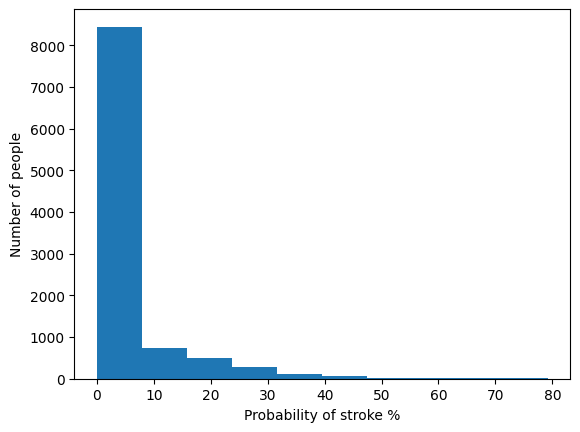

In [31]:
plt.hist(predictions * 100)
plt.xlabel("Probability of stroke %")
plt.ylabel("Number of people")
plt.show()

In [28]:
final_prediction = linearClf.predict_proba(test_data)[:,1]

In [29]:
sub["stroke"] = final_prediction
sub.to_csv("submission.csv", index = False)